In [20]:
import os
from os.path import  join
import re
import keras
from keras.layers import Embedding, Lambda, Dense
from keras.models import Sequential
from keras import backend as K

In [21]:
def clean_str(string, TREC=False):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Every dataset is lower cased except for TREC
    """
    string = re.sub(r"<br />", "", string) 
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)     
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string) 
    string = re.sub(r"n\'t", " n\'t", string) 
    string = re.sub(r"\'re", " \'re", string) 
    string = re.sub(r"\'d", " \'d", string) 
    string = re.sub(r"\'ll", " \'ll", string) 
    string = re.sub(r",", " , ", string) 
    string = re.sub(r"!", " ! ", string) 
    string = re.sub(r"\(", " ( ", string) 
    string = re.sub(r"\)", " ) ", string) 
    string = re.sub(r"\?", " ? ", string) 
    string = re.sub(r"\s{2,}", " ", string)    
    return string.strip().lower()


## 每次产生一个Batch的数据生成器

In [22]:
# 构造训练数据
#path = '/home/bruce/data/sentiment/origin/sentiment_w2v/'\
#path = '/home/bruce/data/sentiment/origin/test'
def lines_Generator(files_path=''):
    for name in os.listdir(path):
        if os.path.isfile(os.path.join(path,name)):
            print('file name =',name)
            for line in open(os.path.join(path,name)):
                yield clean_str(line)
def ngram_Generator(lines_generator = None,ngram=None):
    for line in lines_generator:
        if len(line) <= ngram:
            continue
        label = int(line[0:1])
        words = line[2:].split(' ')
        right = ngram
        for right in range(right , len(words) + 1 , 1):
            if len(words)>=ngram:
                yield (words[right-ngram:right],label)


## 构造word_index

In [23]:
def get_word_index(data_path=''):
    word_index ={}
    count = 1
    for line in lines_Generator(files_path=data_path):
        words = line[2:].split(' ')
        for word in words:
            if word not in word_index:
                word_index[word] = count
                count = count + 1
    print('length of word_index = ',len(word_index))
    return word_index 


## word 转 index

In [24]:
def batch_Generator(ngram_generator=None,batch_size = None):
    batch_x =[]
    batch_y = []
    for ng in ngram_generator:
        indexs = [word_index[w] for w in ng[0]]
        batch_x.append(indexs)
        if ng[1] == 0:
            batch_y.append([1,0])
        else:
            batch_y.append([0,1])
        if len(batch_x) == batch_size:
            yield batch_x,batch_y
            batch_x =[]
            batch_y =[]

In [25]:
path = '/home/bruce/data/sentiment/origin/sentiment_w2v'
word_index = get_word_index(data_path=path)

file name = all_data.txt
length of word_index =  119099


## 构建模型

In [29]:
ngram = 8
max_dim = len(word_index) + 1
batch_size = 50
embedding_dim = 100
def sum_tensor(x,axis=-2):
    return K.sum(x,axis=axis)

def get_output_shape(input_shape):
    shape = list(input_shape)
    print(shape)
    assert len(shape) == 3  # only valid for 2D tensors
    return (None,embedding_dim)

def get_model(max_dim = max_dim,embedding_dim = embedding_dim,ngram = ngram):
    model = Sequential()
    model.add(Embedding(input_dim=max_dim,output_dim=embedding_dim,input_length = ngram))
    print (model.output_shape)
    
    model.add(Lambda(sum_tensor,output_shape=get_output_shape))
    print (model.output_shape)
    model.add(Dense(output_dim=embedding_dim,activation='hard_sigmoid'))
    model.add(Dense(output_dim=2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    return model
model = get_model(max_dim = max_dim,embedding_dim = embedding_dim,ngram = ngram)

(None, 8, 100)
[None, 8, 100]
(None, 100)


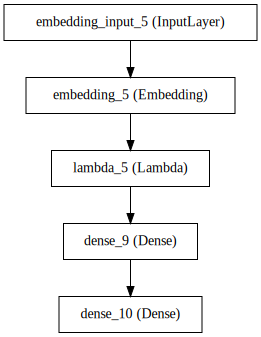

In [30]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:
for epoch in range(20):
    print('epoch = ',epoch)
    lines_ge = lines_Generator(files_path=path)
    ngram_ge = ngram_Generator(lines_generator=lines_ge,ngram=ngram)
    batch_count = 0
    for batch in batch_Generator(ngram_generator=ngram_ge,batch_size=batch_size):
        history = model.train_on_batch(batch[0],batch[1])
        if batch_count % 10000 == 0:
            print('batch ={0} ,result ={1} '.format(batch_count,history))
        batch_count = batch_count + 1 
    print('saving model')
    model.save('/home/bruce/model/sen2vec_model_{}.h5'.format(epoch))

epoch =  0
file name = all_data.txt
batch =0 ,result =[array(0.20701661705970764, dtype=float32), array(1.0, dtype=float32)] 


In [ ]:
len(all_lines)